In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Size of z latent vector ( generator's input )
dim_z = 100

# Size of feature maps in G, D
ngf = 64
ndf = 64

# Number of training epochs
epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 for Adam otimizers
beta1 = 0.5

batch_size = 128

dataset = datasets.CIFAR10
dataset_name = dataset.__module__.split('.')[-1]  # cifar, mnist, ...
img_channels = 3

In [3]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5] * img_channels, [0.5] * img_channels)]) # normalize -1 ~ 1 value

train_dataset = dataset('../dataset/', train=True, download=False, transform=transform)
test_dataset = dataset('../dataset/', train=False, download=False, transform=transform)
dataset = train_dataset + test_dataset

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

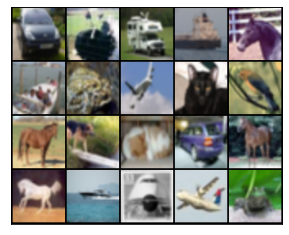

In [4]:
def show(imgs):
    imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def show_sample_image(k=10, nrow=5):
    imgs = next(iter(dataloader))[0]
    imgs = imgs[torch.randperm(imgs.shape[0])[:k]]
    imgs = make_grid(imgs, nrow=nrow, normalize=True)
    show(imgs)

show_sample_image(20, 5)

In [5]:
class Generator(nn.Module):
    def __init__(self, dim_z, img_channels):
        super(Generator, self).__init__()
        
        self.in_channels = dim_z
        self.out_channels = img_channels
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, self.out_channels, 4, 2, 1, bias=False)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.tanh(x)
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, ndf, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.sigmoid(x)
        return x

In [7]:
generator = Generator(dim_z, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

loss_fn = nn.BCELoss()

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal);

In [10]:
def train_dcgan(epochs, save_interval):
    generator.train()
    discriminator.train()
    for epoch in range(epochs):
        for n, (img, _) in enumerate(dataloader):
            img = img.to(device)

            # Generator
            optimizer_g.zero_grad()

            z = torch.randn(batch_size, dim_z, 1, 1).to(device)
            gen_out = generator(z)
            output = discriminator(gen_out)
            score_dgz = output.mean().item()

            loss_g = loss_fn(output, torch.ones_like(output))
            loss_g.backward()
            optimizer_g.step()

            # Discriminator
            optimizer_d.zero_grad()

            output = discriminator(img)
            score_dx = output.mean().item()

            loss_d_real = loss_fn(output, torch.ones_like(output))

            output = discriminator(gen_out.detach())
            loss_d_fake = loss_fn(output, torch.zeros_like(output))

            loss_d = (loss_d_fake + loss_d_real) / 2
            loss_d.backward()
            optimizer_d.step()
            
            if (n + 1) % save_interval == 0:
                print('epoch: [{}/{}], step: [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, D(G(z): {:.4f}, D(x): {:.4f}'
                      .format(epoch+1, epochs, n+1, len(dataloader), loss_g.item(), loss_d.item(), score_dgz, score_dx))
                random_imgs = gen_out[torch.randperm(gen_out.shape[0])[:25]]
                save_image(random_imgs, f'dcgan_img/{dataset_name}/{epoch+1+epoch_}_{n+1}.png', nrow=5, normalize=True)

In [12]:
train_dcgan(epochs=1, save_interval=len(dataloader) // 3)

epoch: [1/1], step: [156/469], loss_g: 4.2482, loss_d: 0.0203, D(G(z): 0.0155, D(x): 0.9785
epoch: [1/1], step: [312/469], loss_g: 4.6675, loss_d: 0.0127, D(G(z): 0.0104, D(x): 0.9869
epoch: [1/1], step: [468/469], loss_g: 6.1439, loss_d: 0.0015, D(G(z): 0.0023, D(x): 0.9994


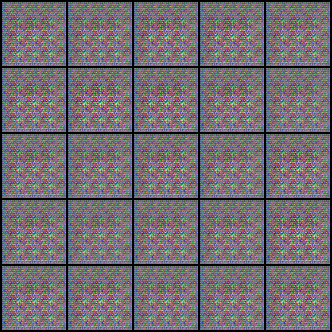

In [13]:
from IPython.display import Image
Image('../GAN/dcgan_img/cifar/1_468.png')

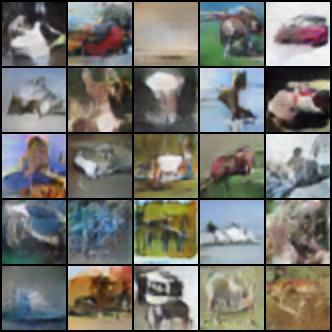

In [14]:
Image('../GAN/dcgan_img/cifar/50_468.png')

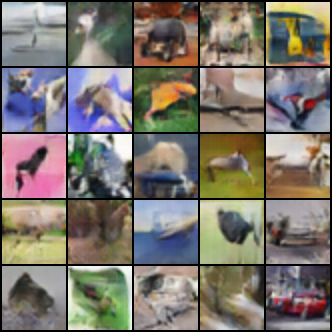

In [15]:
Image('../GAN/dcgan_img/cifar/100_156.png')